In [1]:
#default_exp file_attention

In [2]:
#export
import os
import ast
import tqdm
import json
import attr
from operator import itemgetter

from scarce_learn import zero_shot
from mlutil.feature_extraction import embeddings
import itertools


import pandas as pd
import numpy as np
from sklearn import feature_extraction, metrics, model_selection

import matplotlib.pyplot as plt
import gensim

from github_search import paperswithcode_tasks

import mlutil
from functools import partial


from scarce_learn.zero_shot import devise_jax, devise_torch

In [3]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
import copy

import torch
from torch import nn
from torch.nn import functional as F

from sklearn import model_selection
from transformers import Trainer, TrainingArguments
from transformers import LineByLineTextDataset

from transformers import DataCollatorForLanguageModeling
import tqdm
from transformers import RobertaForCausalLM, RobertaModel
from transformers import AutoTokenizer, AutoModelForCausalLM

In [4]:
%cd ..

/home/kuba/Projects/github_search


In [5]:
all_functions_df = pd.read_csv("output/python_functions.csv", index_col="Unnamed: 0", nrows=500000)

In [6]:
functions_df = all_functions_df.iloc[:500000]

In [7]:
functions_df = functions_df[~functions_df['repo_name'].isin(['tensorflow/models', 'google-research/google-research', 'tensorflow/tensor2tensor', 'yumoh/catboost_iter'] )]

In [8]:
repo_functions_count = functions_df['repo_name'].value_counts()

In [9]:
functions_df = functions_df[functions_df['repo_name'].isin(repo_functions_count[repo_functions_count > 10].index)]

In [10]:
import ast

In [11]:
paperswithcode_with_imports_df = pd.read_csv('output/papers_with_imports.csv')
paperswithcode_with_imports_df['tasks'] = paperswithcode_with_imports_df['tasks'].apply(ast.literal_eval)

In [12]:
functions_df

,repo_name,path,function_name,function_code
0,trangvu/ape-npi,translate/import_graph.py,ImportGraph,class ImportGraph():\n ' Importing and run...
1,trangvu/ape-npi,translate/import_graph.py,load_checkpoint,"def load_checkpoint(sess, checkpoint_dir, file..."
2,trangvu/ape-npi,translate/models.py,auto_reuse,"def auto_reuse(fun):\n ""\n Wrapper that ..."
3,trangvu/ape-npi,translate/models.py,CellWrapper,class CellWrapper(RNNCell):\n '\n Wrappe...
4,trangvu/ape-npi,translate/models.py,multi_encoder,"def multi_encoder(encoder_inputs, encoders, en..."
...,...,...,...,...
499995,huggingface/transformers,tests/test_modeling_deit.py,DeiTModelIntegrationTest,@require_vision\nclass DeiTModelIntegrationTes...
499996,huggingface/transformers,tests/test_feature_extraction_detr.py,DetrFeatureExtractionTester,class DetrFeatureExtractionTester(unittest.Tes...
499997,huggingface/transformers,tests/test_feature_extraction_detr.py,DetrFeatureExtractionTest,@require_torch\n@require_vision\nclass DetrFea...
499998,huggingface/transformers,tests/test_processor_clip.py,CLIPProcessorTest,@require_vision\nclass CLIPProcessorTest(unitt...


In [13]:
functions_df.groupby("repo_name").agg("count")['path'].value_counts()

13      23
15      22
12      21
14      18
21      18
        ..
1200     1
743      1
406      1
531      1
528      1
Name: path, Length: 246, dtype: int64

In [14]:
import sentence_transformers.models

import sentence_transformers

In [15]:
model_name = "microsoft/codebert-base"

In [16]:
sentence_transformer_model = sentence_transformers.SentenceTransformer(model_name)

device = 'cuda' if torch.cuda.is_available() else 'cpu' # Tell pytorch to run this model on the GPU.
tokenizer = RobertaTokenizer.from_pretrained(model_name,truncation = True)
model = RobertaModel.from_pretrained(
    model_name,
    output_attentions = False, 
    output_hidden_states = True,
)
model = model.to(device).half()


path_tokenizer = RobertaTokenizer.from_pretrained(model_name,truncation = True)
path_model = RobertaForMaskedLM.from_pretrained(
    model_name,
    output_attentions = False, 
    output_hidden_states = True,
).roberta
path_model = model.to(device).half()


In [17]:
function_paths = functions_df['repo_name'] + " " + functions_df['path']

In [18]:
functions_grouped = functions_df.groupby(function_paths).apply(lambda df: list(df['function_code']))

In [19]:
functions_grouped.groupby(functions_grouped.index).agg('count')

1jsingh/rl_navigation agents/bst.py                                    1
1jsingh/rl_navigation agents/dqn_agent.py                              1
1jsingh/rl_navigation agents/model.py                                  1
5yearsKim/Conditional-Normalizing-Flow data/dataset.py                 1
5yearsKim/Conditional-Normalizing-Flow inference.py                    1
                                                                      ..
ztoString/CRNN_CTC_OCR_TensorFlow data/create_synth90k_tfrecord.py     1
ztoString/CRNN_CTC_OCR_TensorFlow tools/create_crnn_ctc_tfrecord.py    1
ztoString/CRNN_CTC_OCR_TensorFlow tools/eval_crnn_ctc.py               1
ztoString/CRNN_CTC_OCR_TensorFlow tools/inference_crnn_ctc.py          1
ztoString/CRNN_CTC_OCR_TensorFlow tools/train_crnn_ctc.py              1
Length: 24053, dtype: int64

In [20]:
sum(functions_grouped.iloc[:2], start=[])

['class Node(object):\n\n    def __init__(self, data):\n        self.data = data\n        self.freq = 1\n        self.leftchild = None\n        self.rightchild = None\n\n    def assign(self, another_node):\n        self.data = another_node.data\n        self.freq = another_node.freq\n        self.leftchild = another_node.leftchild\n        self.rightchild = another_node.rightchild\n\n    def remove_child(self, child_node):\n        assert ((child_node == self.leftchild) or (child_node == self.rightchild))\n        if (self.data < child_node.data):\n            self.rightchild = None\n        else:\n            self.leftchild = None',
 "class FixedSize_BinarySearchTree(object):\n\n    def __init__(self, capacity):\n        self.capacity = capacity\n        self.size = 0\n        self.values = deque(maxlen=capacity)\n        self.value_sum = 0\n        self.root = None\n\n    def update(self, value, idx, node=None):\n        '\\n\\t\\tupdate tree node value\\n\\t\\t'\n        assert (idx

In [21]:
function_paths = functions_df['repo_name'] + " " + functions_df['path']

In [22]:
functions_grouped[function_paths.iloc[:5]]

trangvu/ape-npi translate/import_graph.py    [class ImportGraph():\n    '  Importing and ru...
trangvu/ape-npi translate/import_graph.py    [class ImportGraph():\n    '  Importing and ru...
trangvu/ape-npi translate/models.py          [def auto_reuse(fun):\n    "\n    Wrapper that...
trangvu/ape-npi translate/models.py          [def auto_reuse(fun):\n    "\n    Wrapper that...
trangvu/ape-npi translate/models.py          [def auto_reuse(fun):\n    "\n    Wrapper that...
dtype: object

In [23]:
repo_tasks = paperswithcode_with_imports_df[['repo', 'tasks']].groupby('repo').agg(sum)

In [24]:
def get_file_dataset(repo_tasks, functions_df):
    functions_df = functions_df.merge(repo_tasks, left_on='repo_name', right_on='repo')
    function_paths = functions_df['repo_name'] + " " + functions_df['path']
    functions_groupby = functions_df.groupby(function_paths.values)
    functions_grouped = functions_groupby.apply(lambda df: frozenset(df['function_code']))
    tasks_grouped = functions_groupby.apply(lambda df: list(df['tasks']))
    data_df = pd.DataFrame({
        "tasks": tasks_grouped,
        "functions": functions_grouped
    }).explode("tasks").explode("tasks").reset_index().drop_duplicates()
    data_df['functions'] = data_df['functions'].apply(list)
    return data_df

In [25]:
get_file_dataset(repo_tasks, functions_df).groupby('index').agg('count').sort_values('functions')

,tasks,functions
index,,
1jsingh/rl_navigation agents/bst.py,1,1
geomstats/geomstats tests/tests_geomstats/test_normal.py,1,1
geomstats/geomstats tests/tests_geomstats/test_minkowski.py,1,1
geomstats/geomstats tests/tests_geomstats/test_mdm.py,1,1
geomstats/geomstats tests/tests_geomstats/test_matrices.py,1,1
...,...,...
kbardool/mrcnn3 mrcnn/ArchivedCode/model_fcn_02122019.py,13,13
kbardool/mrcnn3 mrcnn/ArchivedCode/model_fcn_09132018_.py,13,13
kbardool/mrcnn3 mrcnn/ArchivedCode/model_fcn_10142018_.py,13,13


In [26]:
def get_sample_indices_iterator(data_df, batch_size=8, shuffle=True):
    sample_index = data_df.index.values
    if shuffle:
        np.random.shuffle(sample_index)
    for i in range(0, len(sample_index), batch_size):
        yield sample_index[i:i+batch_size]

In [27]:
data_df = get_file_dataset(repo_tasks, functions_df)
sample_index = data_df.index.values
np.random.shuffle(sample_index)

In [28]:
data_df

,index,tasks,functions
25877,1jsingh/rl_navigation agents/bst.py,Atari Games,[class FixedSize_BinarySearchTree(object):\n\n...
107121,1jsingh/rl_navigation agents/dqn_agent.py,Atari Games,"[class Agent():\n\n def __init__(self, stat..."
28117,1jsingh/rl_navigation agents/model.py,Atari Games,[class Qnetwork(nn.Module):\n\n def __init_...
54028,5yearsKim/Conditional-Normalizing-Flow data/da...,Colorization,[def files_to_list(filename):\n '\n Take...
199950,5yearsKim/Conditional-Normalizing-Flow data/da...,Image Generation,[def files_to_list(filename):\n '\n Take...
...,...,...,...
65257,ztoString/CRNN_CTC_OCR_TensorFlow tools/eval_c...,Scene Text Recognition,"[def main(unused_argv):\n _eval_crnn_ctc(),..."
273546,ztoString/CRNN_CTC_OCR_TensorFlow tools/infere...,Scene Text,"[def _int_to_string(value, char_map_dict=None)..."
15792,ztoString/CRNN_CTC_OCR_TensorFlow tools/infere...,Scene Text Recognition,"[def _int_to_string(value, char_map_dict=None)..."
23656,ztoString/CRNN_CTC_OCR_TensorFlow tools/train_...,Scene Text,[def _train_crnn_ctc():\n tfrecord_path = o...


In [29]:
index_iter = get_sample_indices_iterator(data_df, batch_size=8)

In [30]:
def prepare_model_inputs(batch):
    indices = list(np.cumsum(batch['functions'].apply(len).values))
    file_function_idxs_start = np.array([0] + indices[:-1])
    file_function_idxs_end = indices
    reshaped_batch = batch.explode("functions")
    
    return batch['tasks'].values, batch['index'].values, reshaped_batch['functions'].values, file_function_idxs_start, file_function_idxs_end

In [31]:
batch = data_df.iloc[next(iter(index_iter))]
batch_tasks, batch_paths, batch_functions, file_function_idxs_start, file_function_idxs_end = prepare_model_inputs(batch)

IndexError: positional indexers are out-of-bounds

In [32]:
batch_functions

NameError: name 'batch_functions' is not defined

In [33]:
file_function_idxs_start

NameError: name 'file_function_idxs_start' is not defined

In [34]:
file_function_idxs_end

NameError: name 'file_function_idxs_end' is not defined

# Idea: use thinc

In [35]:
def get_embeddings(model, tokenizer, texts, max_length=512):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, max_length=max_length)
    inputs['input_ids'] = inputs['input_ids'][:,:max_length]
    inputs['attention_mask'] = inputs['attention_mask'][:,:max_length]
    inputs = inputs.to(model.device)
    return model(**inputs).last_hidden_state.mean(axis=1)

#path_embeddings = get_embeddings(model, tokenizer, paths_batch)#.last_hidden_state.mean(axis=1)

In [36]:
#function_embeddings = get_embeddings(model, tokenizer, functions_batch)

In [37]:
#function_embeddings.dtype

In [38]:
#functions_embeddings_reshaped = function_embeddings.repeat((5,1,1))

In [39]:
# zrób dla jednego

In [40]:
#first_file_functions = function_embeddings[file_function_idxs_start[0]:file_function_idxs_end[0]]

In [41]:
#path_embeddings.shape
#first_file_functions

In [42]:
class CrossAttentionSelector(nn.Module):
    
    def __init__(self):
        super(CrossAttentionSelector, self).__init__()
    
    def forward(self, path_embeddings, function_embeddings, file_function_idxs_start, file_function_idxs_end):
        attn = F.sigmoid(path_embeddings @ function_embeddings.T)
        attn_mask= torch.ones_like(attn).cuda().half()
        for i in range(len(file_function_idxs_start)):
            attn_mask[i,:file_function_idxs_start[i]]= 0
            attn_mask[i,file_function_idxs_end[i]:] = 0
        return (attn_mask * attn) @ function_embeddings 

In [43]:
selector = CrossAttentionSelector().cuda().half()

In [44]:
class PathBasedFileEmbedder(nn.Module):
    
    def __init__(self, embedding_features, hidden_size, dropout_prob=0.5):
        super(PathBasedFileEmbedder, self).__init__()
        self.cross_attention_pooler = CrossAttentionSelector()
        self.path_dense = nn.Linear(embedding_features, hidden_size)
        self.function_dense = nn.Linear(embedding_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        
    def forward(self, path_embeddings, function_embeddings, file_function_idxs_start, file_function_idxs_end):
        path_nl_embeddings = F.leaky_relu(
            self.bn1(
                self.path_dense(path_embeddings)
            )
        )
        function_nl_embeddings = F.leaky_relu(
            self.bn2(
                self.function_dense(
                    function_embeddings)
            )
        )
        file_embeddings = self.cross_attention_pooler(path_nl_embeddings, function_nl_embeddings, file_function_idxs_start, file_function_idxs_end)
        return (
            path_nl_embeddings,
            F.leaky_relu(
                self.bn3(file_embeddings) 
            )
        )

In [45]:
file_embedder = PathBasedFileEmbedder(768, 20).cuda().half()

In [46]:
path_embeddings = sentence_transformer_model.encode(batch_paths, convert_to_numpy=False, convert_to_tensor=True).half()
function_embeddings = sentence_transformer_model.encode(batch_functions, convert_to_numpy=False, convert_to_tensor=True).half()
task_embeddings = sentence_transformer_model.encode(batch_tasks, convert_to_numpy=False, convert_to_tensor=True).half()

NameError: name 'batch_paths' is not defined

In [ ]:
selector(path_embeddings, function_embeddings, file_function_idxs_start, file_function_idxs_end)

In [ ]:
len(path_embeddings)

In [47]:
class TripleSimilarityHead(nn.Module):
    
    def __init__(self, input_size, hidden_size=64):
        super(TripleSimilarityHead, self).__init__()
        self.input_size = input_size
        
    def forward(self, u, v, reference):
        #imilarity_features = torch.column_stack(
        #    [u, v, torch.abs(u-reference), torch.abs(v-reference)]
        #)
        #hidden = F.tanh(self.bn(self.dense(similarity_features)))
        return torch.column_stack(
            [
                torch.cosine_similarity(u, reference),
                torch.cosine_similarity(v, reference)
            ])

In [48]:
import sentence_transformers

In [49]:
a = list(range(5))

a[2:]

[2, 3, 4]

In [50]:
class AggregateSimilarityScorer(nn.Module):
    
    def __init__(self,
                 sentence_transformer,
                 embedding_features,
                 hidden_size,
                 dropout_prob=0.5):
        super(AggregateSimilarityScorer, self).__init__()
        self.sentence_transformer = sentence_transformer
        self.file_embedder = PathBasedFileEmbedder(embedding_features, hidden_size)
        self.task_dense = nn.Linear(embedding_features, hidden_size)
        self.similarity_head = TripleSimilarityHead(hidden_size)
        self.bn_task = nn.BatchNorm1d(hidden_size)
        self.transformer_batch_size = 512
        
    def get_trainable_params(self):
        return itertools.chain(
            self.file_embedder.parameters(),
            self.task_dense.parameters(),
            self.similarity_head.parameters(),
            self.bn_task.parameters()
        )
    
    def embed_tasks(self, tasks):
        with torch.no_grad():
            base_embeddings = self.sentence_transformer.encode(tasks, convert_to_numpy=False, convert_to_tensor=True).half()
        task_embeddings = F.leaky_relu(
            self.bn_task(self.task_dense(base_embeddings))
        )
        return task_embeddings
        
    def forward(self, tasks, tasks_negative, paths, functions, file_function_idxs_start, file_function_idxs_end):
        all_inputs = list(tasks) + list(paths) + list(functions) + list(tasks_negative)
        embeddings = self.sentence_transformer.encode(all_inputs, convert_to_numpy=False, convert_to_tensor=True, batch_size=self.transformer_batch_size).half()
        base_task_embeddings = embeddings[:len(tasks)] 
        base_path_embeddings = embeddings[len(tasks):len(tasks) + len(paths)] 
        function_embeddings = embeddings[ len(tasks) + len(paths):-len(tasks_negative)]
        base_negative_task_embeddings = embeddings[-len(tasks_negative):]
        task_embeddings = F.leaky_relu(
            self.bn_task(self.task_dense(base_task_embeddings))
        )
        negative_task_embeddings = F.leaky_relu(
            self.bn_task(self.task_dense(base_negative_task_embeddings))
        )
        path_embeddings, file_embeddings = self.file_embedder(
            base_path_embeddings,
            function_embeddings,
            file_function_idxs_start,
            file_function_idxs_end)
        positive_similarity = self.similarity_head(
            path_embeddings,
            file_embeddings,
            task_embeddings
        )
        negative_similarity = self.similarity_head(
            path_embeddings,
            file_embeddings,
            negative_task_embeddings
        )
        return positive_similarity, negative_similarity
    
    def embed_files(self, paths, functions, file_function_idxs_start, file_function_idxs_end):
        with torch.no_grad():
            path_embeddings = self.sentence_transformer.encode(paths, convert_to_numpy=False, convert_to_tensor=True, batch_size=self.transformer_batch_size).half()
            function_embeddings = self.sentence_transformer.encode(functions, convert_to_numpy=False, convert_to_tensor=True, batch_size=self.transformer_batch_size).half()
            path_embeddings, file_embeddings = self.file_embedder(
                path_embeddings,
                function_embeddings,
                file_function_idxs_start,
                file_function_idxs_end
            )
        return path_embeddings, file_embeddings

In [51]:
embedding_features = 768

In [52]:
#path_embeddings.shape#* functions_embeddings_reshaped

In [53]:
sentence_transformer_model = sentence_transformer_model.half()

In [54]:
similarity_scorer = AggregateSimilarityScorer(
    sentence_transformer_model,
    embedding_features=embedding_features,
    hidden_size=512
).cuda().half()

In [55]:
similarity_scorer

AggregateSimilarityScorer(
  (sentence_transformer): SentenceTransformer(
    (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  )
  (file_embedder): PathBasedFileEmbedder(
    (cross_attention_pooler): CrossAttentionSelector()
    (path_dense): Linear(in_features=768, out_features=512, bias=True)
    (function_dense): Linear(in_features=768, out_features=512, bias=True)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (task_dense): Linear(in_features=768, out_features=512, bias=True)
  (similarity_head): Trip

In [56]:
tasks_batch = ["classification"] + ["domain adaptation"] * 4

base_path_embeddings = get_embeddings(model, tokenizer, paths_batch)
function_embeddings = get_embeddings(model, tokenizer, functions_batch)
base_task_embeddings = get_embeddings(model, tokenizer, tasks_batch)

In [57]:
batch_paths.shape

NameError: name 'batch_paths' is not defined

In [58]:
batch_tasks.shape

NameError: name 'batch_tasks' is not defined

In [59]:
random_tasks

NameError: name 'random_tasks' is not defined

In [60]:
scores = similarity_scorer(batch_tasks, random_tasks, batch_paths, batch_functions, file_function_idxs_start, file_function_idxs_end)
#negative_scores = similarity_scorer(random_tasks, batch_paths, batch_functions, file_function_idxs_start, file_function_idxs_end)

NameError: name 'batch_tasks' is not defined

In [61]:
import itertools

In [65]:
import livelossplot

In [66]:
batch_size = 16 

In [67]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [68]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.05):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        if self.training:
            x = x.float()
            target = target.float()
            logprobs = torch.nn.functional.logsigmoid(x)
            minus_logprobs = torch.nn.functional.logsigmoid(-x)
    
            target_smoothed = target * (1-self.smoothing) + self.smoothing/2
            smoothed_loss =  -logprobs * target_smoothed - minus_logprobs * (1 - target_smoothed)
            return smoothed_loss.mean()
        else:
            return torch.nn.functional.cross_entropy(x, target)

In [69]:
label_smoothing = LabelSmoothing(0)

In [70]:
log_probs = torch.tensor([-100,100]).float().reshape(2,1)#('int')

In [71]:
targets = torch.tensor([0,1]).reshape(2,1)

In [72]:
log_probs

tensor([[-100.],
        [ 100.]])

In [73]:
log_probs.shape

torch.Size([2, 1])

In [74]:
targets.shape

torch.Size([2, 1])

In [75]:
label_smoothing(log_probs, targets)

tensor(0.)

In [76]:
import paperswithcode
import pandas as pd


def get_area_grouped_tasks():
    client = paperswithcode.PapersWithCodeClient()
    areas = client.area_list().results
    s = 0

    area_grouped_tasks = {}

    for a in areas:
        area_tasks = [t.id for t in client.area_task_list(a.id, items_per_page=1000).results]
        area_grouped_tasks[a.id] = area_tasks
        n_tasks_per_area = len(area_tasks)
        print(a.id, ':', n_tasks_per_area)
        s += n_tasks_per_area
    tasks_df = pd.DataFrame({'area': area_grouped_tasks.keys(), 'task': area_grouped_tasks.values()}).explode('task')
    tasks_df['task'] = tasks_df['task'].str.split("-").apply(" ".join)
    return tasks_df

In [77]:
area_grouped_tasks = get_area_grouped_tasks()

adversarial : 12
audio : 38
computer-code : 38
computer-vision : 500
graphs : 60
knowledge-base : 21
medical : 195
methodology : 144
miscellaneous : 140
music : 16
natural-language-processing : 429
playing-games : 39
reasoning : 16
robots : 30
speech : 50
time-series : 61


In [80]:
data_df['tasks'] = data_df['tasks'].str.lower()

In [81]:
unique_tasks = data_df['tasks'].drop_duplicates()

In [93]:
areas = [
    area_grouped_tasks[area_grouped_tasks['task'] == t]
    for t in unique_tasks
]

In [94]:
areas[3]

,area,task
10,natural-language-processing,dialogue generation
14,speech,dialogue generation


In [95]:
def get_task_area(task):
    maybe_area = area_grouped_tasks[area_grouped_tasks['task'] == task]['area']
    if len(maybe_area) == 0:
        return area_grouped_tasks['area'].sample(1).iloc[0]
    else:
        return maybe_area.iloc[0]

In [96]:
def get_random_non_matching_task(task):
    task_area = get_task_area(task)
    return area_grouped_tasks[area_grouped_tasks['area'] != task_area].sample(1).iloc[0]['task']

In [103]:
get_random_non_matching_task('atari games')

'multi modal subspace clustering'

In [85]:
non_matching_tasks = dict([
    (t, [get_random_non_matching_task(t) for __ in range(10)])
    for t in unique_tasks
])

In [86]:
dict(non_matching_tasks)

{'atari games': ['model extraction',
  'self knowledge distillation',
  'core set discovery',
  'hypothesis testing',
  'complaint comment classification',
  'lake ice detection',
  'ad hoc information retrieval',
  'multiple affordance detection',
  'physics informed machine learning',
  'lake ice detection'],
 'colorization': ['semantic role labeling',
  'temporal information extraction',
  'drs parsing',
  'question generation',
  'dialog learning',
  'fact based text editing',
  'unsupervised dependency parsing',
  'protein function prediction',
  'negation detection',
  'speaker identification'],
 'image generation': ['motion planning',
  'few shot ner',
  'constituency parsing',
  'protein structure prediction',
  'semi supervised text classification 1',
  'numerical integration',
  'temporal logic',
  'injury prediction',
  'component classification',
  'oceanic eddy classification'],
 'dialogue generation': ['3d point cloud matching',
  'yield mapping in apple orchards',
  'fin

In [87]:
import random

In [88]:
non_matching_tasks

{'atari games': ['model extraction',
  'self knowledge distillation',
  'core set discovery',
  'hypothesis testing',
  'complaint comment classification',
  'lake ice detection',
  'ad hoc information retrieval',
  'multiple affordance detection',
  'physics informed machine learning',
  'lake ice detection'],
 'colorization': ['semantic role labeling',
  'temporal information extraction',
  'drs parsing',
  'question generation',
  'dialog learning',
  'fact based text editing',
  'unsupervised dependency parsing',
  'protein function prediction',
  'negation detection',
  'speaker identification'],
 'image generation': ['motion planning',
  'few shot ner',
  'constituency parsing',
  'protein structure prediction',
  'semi supervised text classification 1',
  'numerical integration',
  'temporal logic',
  'injury prediction',
  'component classification',
  'oceanic eddy classification'],
 'dialogue generation': ['3d point cloud matching',
  'yield mapping in apple orchards',
  'fin

In [89]:
random.choice(non_matching_tasks['atari games'])

'lake ice detection'

In [245]:
similarity_scorer = AggregateSimilarityScorer(
    sentence_transformer_model,
    embedding_features=embedding_features,
    hidden_size=512
).cuda().half()

In [94]:
params = similarity_scorer.get_trainable_params()
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.5, nesterov=True)
batch_size = 32

In [ ]:
plt.style.use("dark_background")

In [ ]:
import livelossplot

In [ ]:
label_smoothing = LabelSmoothing(0.05)

In [ ]:
batch_size

In [229]:
similarity_scorer = torch.load("output/similarity_scorer.pt")#.state_dict()
similarity_scorer.transformer_batch_size = 512

In [ ]:
batch

In [ ]:
??prepare_model_inputs

In [ ]:
inputs = prepare_model_inputs(batch)
len(inputs)

In [ ]:
inputs[-2]

In [ ]:
path_embeddings, file_embeddings = similarity_scorer.embed_files(*inputs[1:])

In [96]:
def get_batched_outputs(model, input, batch_size=256):
    outputs = []
    with torch.no_grad():
        for i in range(int(np.ceil(len(input) / batch_size))):
            batch_outputs = model(input[i*batch_size:(i+1)*batch_size])
            outputs.append(batch_outputs.cpu().numpy())
            
    return np.row_stack(outputs)

In [230]:
def prepare_path_file_features(similarity_scorer, data_df, batch_size=128):
    index_iterator = get_sample_indices_iterator(data_df, batch_size=batch_size, shuffle=False)
    all_path_embeddings = []
    all_file_embeddings = []
    with torch.no_grad():
        for indices in tqdm.tqdm(index_iterator, total=np.ceil(len(data_df) / batch_size)):
            batch = data_df.iloc[indices]
            __, batch_paths, batch_functions, file_function_idxs_start, file_function_idxs_end = prepare_model_inputs(batch)
            path_embeddings, file_embeddings = similarity_scorer.embed_files(batch_paths, batch_functions, file_function_idxs_start, file_function_idxs_end)
            all_path_embeddings.append(path_embeddings.cpu().numpy())
            all_file_embeddings.append(file_embeddings.cpu().numpy())
    return np.row_stack(all_path_embeddings), np.row_stack(all_file_embeddings)

In [231]:
sample_data_df['tasks'] = sample_data_df['tasks'].str.lower()

In [246]:
sample_data_df = data_df.iloc[:1000].reset_index(drop=True)
from sklearn import metrics

task_embeddings = get_batched_outputs(similarity_scorer.embed_tasks, area_grouped_tasks['task'].values)

matching_task_embeddings = get_batched_outputs(similarity_scorer.embed_tasks, sample_data_df['tasks'].values)

In [247]:
path_features, file_features = prepare_path_file_features(similarity_scorer, sample_data_df, batch_size=128)

  0%|          | 0/8.0 [00:00<?, ?it/s]/home/kuba/.local/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 8/8.0 [00:09<00:00,  1.16s/it]


In [248]:
matching_path_task_similarity = np.diag(metrics.pairwise.cosine_similarity(path_features, matching_task_embeddings))
matching_file_task_similarity = np.diag(metrics.pairwise.cosine_similarity(file_features, matching_task_embeddings))

path_task_similarity = metrics.pairwise.cosine_similarity(path_features, task_embeddings)
file_task_similarity = metrics.pairwise.cosine_similarity(file_features, task_embeddings)

In [249]:
sample_data_df

,index,tasks,functions
0,1jsingh/rl_navigation agents/bst.py,Atari Games,[class FixedSize_BinarySearchTree(object):\n\n...
1,1jsingh/rl_navigation agents/dqn_agent.py,Atari Games,"[class Agent():\n\n def __init__(self, stat..."
2,1jsingh/rl_navigation agents/model.py,Atari Games,[class Qnetwork(nn.Module):\n\n def __init_...
3,5yearsKim/Conditional-Normalizing-Flow data/da...,Colorization,[def files_to_list(filename):\n '\n Take...
4,5yearsKim/Conditional-Normalizing-Flow data/da...,Image Generation,[def files_to_list(filename):\n '\n Take...
...,...,...,...
995,AnshanTJU/FILD FILD++/research/object_detectio...,Loop Closure Detection,[@parameterized.parameters({'replace_pool_with...
996,AnshanTJU/FILD FILD++/research/object_detectio...,Simultaneous Localization and Mapping,[@parameterized.parameters({'replace_pool_with...
997,AnshanTJU/FILD FILD++/research/object_detectio...,Image Retrieval,"[def _obtain_input_shape(input_shape, default_..."
998,AnshanTJU/FILD FILD++/research/object_detectio...,Loop Closure Detection,"[def _obtain_input_shape(input_shape, default_..."


In [250]:
pd.Series(matching_path_task_similarity).describe()

count    1000.000000
mean        0.350911
std         0.037332
min         0.231105
25%         0.324754
50%         0.350680
75%         0.374555
max         0.453452
dtype: float64

In [251]:
pd.Series(path_task_similarity.reshape(-1)).describe()

count    1.788000e+06
mean     3.265582e-01
std      3.360806e-02
min      1.824345e-01
25%      3.037865e-01
50%      3.263837e-01
75%      3.491307e-01
max      4.700583e-01
dtype: float64

In [252]:
pd.Series(matching_file_task_similarity + matching_path_task_similarity).describe()

count    1000.000000
mean        0.559866
std         0.175104
min        -0.246787
25%         0.461388
50%         0.554016
75%         0.671504
max         1.012791
dtype: float64

In [253]:
pd.Series((path_task_similarity+ file_task_similarity).reshape(-1)).describe()

count    1.788000e+06
mean     5.219940e-01
std      1.636570e-01
min     -3.081890e-01
25%      4.312267e-01
50%      5.213256e-01
75%      6.274355e-01
max      9.978057e-01
dtype: float64

In [254]:
path_task_similarity.shape

(1000, 1788)

In [255]:
pd.Series((path_task_similarity / matching_path_task_similarity[:,np.newaxis]).reshape(-1)).describe()

count    1.788000e+06
mean     9.396823e-01
std      1.291822e-01
min      4.881841e-01
25%      8.487367e-01
50%      9.310800e-01
75%      1.021130e+00
max      1.770053e+00
dtype: float64

In [256]:
pd.Series((file_task_similarity / matching_file_task_similarity[:,np.newaxis]).reshape(-1)).describe()

count    1.788000e+06
mean     9.634850e-01
std      1.496099e+00
min     -6.328697e+01
25%      7.947853e-01
50%      9.292000e-01
75%      1.078048e+00
max      1.058976e+02
dtype: float64

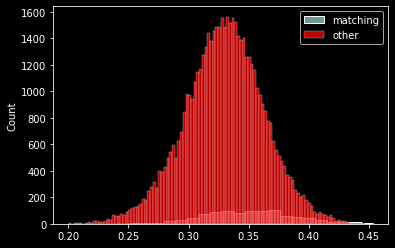

In [257]:
import seaborn as sns

sns.histplot(matching_path_task_similarity.reshape(-1), label='matching')
sns.histplot(path_task_similarity[:30].reshape(-1), label='other', color='red')
plt.legend()

In [ ]:
sns.histplot(matching_file_task_similarity.reshape(-1), label='matching', color='red')
plt.show()
sns.histplot(file_task_similarity.reshape(-1), label='other', alpha=0.5)
plt.legend()

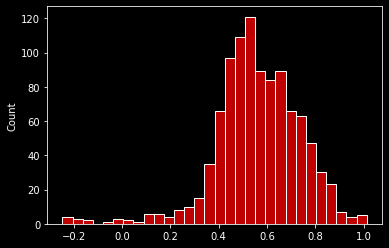

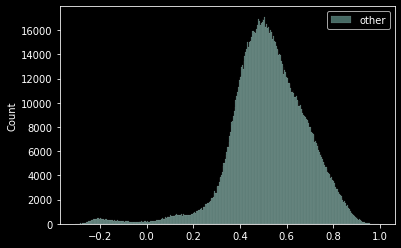

In [258]:
sns.histplot((matching_path_task_similarity + matching_file_task_similarity), label='matching', color='red')
plt.show()
sns.histplot((path_task_similarity + file_task_similarity).reshape(-1), label='other', alpha=0.5)
plt.legend()

In [259]:
task_embeddings

array([[-2.6932e-03,  1.5596e+00,  9.1748e-01, ..., -8.0566e-03,
         2.8320e-01, -2.8820e-03],
       [-2.8152e-03, -1.4427e-02, -9.4223e-03, ..., -7.9575e-03,
         2.2546e-01,  1.4902e+00],
       [ 1.0029e+00,  2.9614e-01,  1.5742e+00, ...,  4.0308e-01,
        -1.1116e-02, -1.1398e-02],
       ...,
       [-5.2910e-03, -1.9388e-03, -1.3857e-03, ..., -5.8212e-03,
         8.0762e-01,  8.1836e-01],
       [-1.0452e-02, -3.2854e-04, -1.2674e-03, ..., -1.7822e-02,
        -4.9858e-03,  1.8418e+00],
       [ 1.3635e-01,  2.5711e-02, -9.4986e-03, ...,  1.5808e-01,
         2.9272e-01,  3.5791e-01]], dtype=float16)

In [ ]:
# Dla pojedynczego negatywnego taska problem jest za łatwy i się nie generalizuje - trzeba zrobić jakiś ranking czy coś

In [ ]:
plotlosses = livelossplot.PlotLosses(from_step=1)

for epoch in range(1):
    print('epoch', epoch)
    index_iterator = get_sample_indices_iterator(data_df, batch_size=batch_size)
    non_matching_tasks = dict([
        (t, [get_random_non_matching_task(t) for __ in range(10)])
        for t in unique_tasks
    ])
    n_batches = np.ceil(len(data_df) / batch_size)
    for i, batch_indices in tqdm.tqdm(enumerate(index_iterator), total=n_batches):
        batch = data_df.iloc[batch_indices]
        batch_tasks, batch_paths, batch_functions, file_function_idxs_start, file_function_idxs_end = prepare_model_inputs(batch)
        random_tasks = [random.choice(non_matching_tasks[t]) for t in batch_tasks]
        scores, negative_scores = similarity_scorer(batch_tasks, random_tasks, batch_paths, batch_functions, file_function_idxs_start, file_function_idxs_end)
        scores = scores.sum(dim=-1, keepdim=True)
        negative_scores = negative_scores.sum(dim=-1, keepdim=True)
        all_scores = torch.cat([scores, negative_scores])
        label = torch.ones(len(batch)* 2, 1).cuda().half()
        label[batch_size:] = 0
        
        loss = label_smoothing(all_scores, label)
        loss.backward()
        optimizer.step()
        acc =((scores > negative_scores)).float().mean().item()#detach().cpu().numpy().mean()
        plotlosses.update({"loss": loss.item(), "accuracy": acc})
        if i % 5 == 0:
            plotlosses.send()

In [ ]:
!ls 

In [ ]:
!ls o

In [ ]:
#torch.save(similarity_scorer, "output/similarity_scorer.pt")#.state_dict()

In [ ]:
random_tasks = repo_tasks.sample(10).explode("tasks").sample(len(batch_tasks))['tasks'].values

In [ ]:
batch_tasks

In [ ]:
random_tasks

In [ ]:
import thinc

batch size mismatch

In [ ]:
len(functions_batch)

In [ ]:
functions_batch

In [ ]:
model.b

In [ ]:
function_embeddings = get_embedding(model, tokenizer, functions_batch).last_hidden_state

In [ ]:
function_embeddings.shape

In [ ]:
function_embeddings.shape

In [ ]:
torch.nn.Sigmoid()(embeddings)